# BERT Classifier for Potential EMA/EMI Repositories Using Descriptive Texts

In [ ]:
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random

## Load the Data

In [ ]:
datapath = '/content/drive/My Drive/emaemi_text.csv'  # same file also in the directory
df = pd.read_csv(datapath)
df.head()

,label,name,description,readme
0,1,ohmyform,"free open source alternative to typeform, tell...",!ohmyform # ohmyform !project status !latest r...
1,1,stopp-corona-android,android source code,"align=""center""> <br> <img src=""./app/src/main/..."
2,1,RADAR-Questionnaire,questionnaire mobile application (active app) ...,## radar-questionnaire !travis ci [!bch compli...
3,1,c3-pro-ios-framework,combining fhir and researchkit,"<img src=""./assets/logo.png"" this is the **ios..."
4,0,della,della is a django app for managing secret sant...,# della della is a django app for managing sec...


In [ ]:
print(f'Num EMA/EMI: {df[df.label == 1].shape[0]}\n'
      f'Num unrelated: {df[df.label == 0].shape[0]}\n'
      f'  => balance {df[df.label == 1].shape[0] / df[df.label == 0].shape[0]}')

Num EMA/EMI: 147
Num unrelated: 125
  => balance 1.176


## Prepare Data (Text Cleaning already Done during Creation)

In [ ]:
# getting a map to display labels later on
labels_dict = {0: 'Unrelated', 1: 'Potential EMA/EMI'}
labels_dict_inv = {'Unrelated': 0, 'Potential EMA/EMI': 1}

# 85% test 15% val data
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=df.label.values)

# appending dataframe with type column to label data directly in df
df['data_type'] = ['not_set'] * df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [ ]:
# print makeup of datasets
df.groupby(['label', 'data_type']).count()

name  description  readme
label data_type                           
0     train       106          106     106
      val          19           19      19
1     train       125          125     125
      val          22           22      22

## Setup BERT Tokenizer and Create PyTorch Datasets with Encoded Data

In [ ]:
BERT_model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(BERT_model_name,
                                          do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# encode data
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type == 'train'].name.values + ' ' + df[df.data_type == 'train'].description.values + ' ' + df[df.data_type == 'train'].readme.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)
encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type == 'val'].name.values + ' ' + df[df.data_type == 'val'].description.values + ' ' + df[df.data_type == 'val'].readme.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=512,
    truncation=True,
    return_tensors='pt'
)

# get input_ids, attention_masks and labels
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df['data_type'] == 'train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df['data_type'] == 'val'].label.values)

In [ ]:
# create PyTorch datasets from those
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train,
                              labels_train)
dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val,
                            labels_val)

# create PyTorch dataloaders
batch_size = 4

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)
dataloader_val = DataLoader(dataset_val,
                            sampler=RandomSampler(dataset_val),
                            batch_size=batch_size)

## Setup BERT Pretrained Model

In [ ]:
model = BertForSequenceClassification.from_pretrained(BERT_model_name,
                                                      num_labels = len(labels_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Setup Training Prerequisites

In [ ]:
# optimizer: AdamW just like original BERT
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

# scheduler: with warmup just like original BERT
epochs = 10
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# defining performance metrics
def f1_score_func(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
  preds_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()

  for label in np.unique(labels_flat):
    y_preds = preds_flat[labels_flat==label]
    y_true = labels_flat[labels_flat==label]
    print(f'Class: {labels_dict[label]}')
    print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Training

In [ ]:
# setting seed for all used RNGs
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# setting up torch device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # single thredded GPU usage
model.to(device)
print(device)

cuda:0


In [ ]:
# eval function to clean up training loop
def evaluate(dataloader_val):
  model.eval()

  loss_val_total = 0
  predictions, true_vals = [], []

  for batch in tqdm(dataloader_val):
    # move batch to GPU if possible
    batch = tuple(b.to(device) for b in batch)

    # form input dict for model
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}

    # forward pass without gradient
    with torch.no_grad():
      outputs = model(**inputs)

    # read out outputs
    loss = outputs[0]
    logits = outputs[1]

    loss_val_total += loss.item()  # append to total loss

    logits = logits.detach().cpu().numpy()
    predictions.append(logits)  # append to predictions

    labels_id = inputs['labels'].cpu().numpy()
    true_vals.append(labels_id)  # append to true values

  # calculate average loss over all batches
  loss_val_avg = loss_val_total / len(dataloader_val)

  predictions = np.concatenate(predictions, axis=0)
  true_vals = np.concatenate(true_vals, axis=0)
  return loss_val_avg, predictions, true_vals

In [ ]:
# create model storage directory if it doesn't already exist
!mkdir Models -p

In [ ]:
# actual training loop
for epoch in tqdm(range(1, epochs+1)):
  model.train()
  loss_train_total = 0

  progress_bar = tqdm(dataloader_train,
                      desc='Epoch {:1d}'.format(epoch),
                      leave=False,
                      disable=False)

  for batch in progress_bar:
    model.zero_grad()
    # move batch to GPU if possible
    batch = tuple(b.to(device) for b in batch)

    # form input dict for model
    inputs = {'input_ids': batch[0],
              'attention_mask': batch[1],
              'labels': batch[2]}

    # forward pass
    outputs = model(**inputs)

    # read out loss and add to total loss
    loss = outputs[0]
    loss_train_total += loss.item()

    # backward pass
    loss.backward()

    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # optimizer magic
    optimizer.step()
    scheduler.step()

    progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})

  # save model after each epoch
  torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')

  # post epoch stats
  tqdm.write(f'\nEpoch {epoch}')
  loss_train_avg = loss_train_total / len(dataloader_train)
  tqdm.write(f'Training loss: {loss_train_avg}')

  # evaluation
  val_loss, predictions, true_vals = evaluate(dataloader_val)
  val_f1 = f1_score_func(predictions, true_vals)
  tqdm.write(f'Validation loss: {val_loss}')
  tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7095783984866636


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6941985542123968
F1 Score (weighted): 0.3747580332946187


Epoch 2:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6663337699298201


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6833588508042422
F1 Score (weighted): 0.6001541911970845


Epoch 3:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5728752643897616


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6182132796807722
F1 Score (weighted): 0.6030607364897178


Epoch 4:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4509674346652524


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.6858169002966448
F1 Score (weighted): 0.5807445442875482


Epoch 5:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2982976087208452


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.635786006396467
F1 Score (weighted): 0.5562492706266776


Epoch 6:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.23717260514867716


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.7133148603818633
F1 Score (weighted): 0.675083337104243


Epoch 7:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.14510336563248058


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.731033518910408
F1 Score (weighted): 0.6908067542213883


Epoch 8:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.10569692884796653


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.8619937293908813
F1 Score (weighted): 0.6908067542213883


Epoch 9:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.07957903604055273


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.8257571071047675
F1 Score (weighted): 0.6470121951219513


Epoch 10:   0%|          | 0/58 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.05019787891671575


  0%|          | 0/11 [00:00<?, ?it/s]

Validation loss: 0.8558998963033612
F1 Score (weighted): 0.6250961581972034


In [ ]:
# just looking at the results of last evaluation
accuracy_per_class(predictions, true_vals)

Class: Unrelated
Accuracy: 9/19

Class: Potential EMA/EMI
Accuracy: 17/22



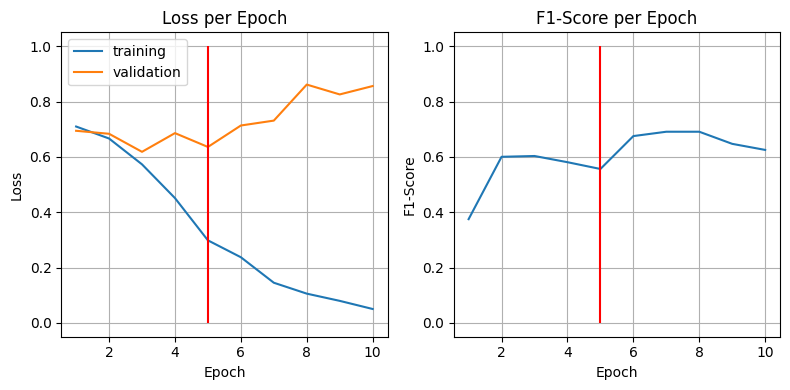

In [ ]:
import matplotlib.pyplot as plt

# hardcoded for diagram
loss_train = [0.7096, 0.6663, 0.5729, 0.4510, 0.2983, 0.2372, 0.1451, 0.1057, 0.0796, 0.0502]
loss_val = [0.6942, 0.6834, 0.6182, 0.6858, 0.6358, 0.7133, 0.7310, 0.8612, 0.8256, 0.8559]
f1 = [0.3748, 0.6002, 0.6031, 0.5807, 0.5562, 0.6751, 0.6908, 0.6908, 0.6470, 0.6251]
acc_unrelated = 9/19
acc_potential = 17/22

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=((8, 4)))
ax = ax.flatten()

xs = list(range(1, 11, 1))

ax[0].plot(xs, loss_train, label='training')
ax[0].plot(xs, loss_val, label='validation')
ax[0].vlines(5, 0, 1, colors='r')
ax[0].legend()
ax[0].grid()
ax[0].set_title('Loss per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(xs, f1)
ax[1].vlines(5, 0, 1, colors='r')
ax[1].grid()
ax[1].set_title('F1-Score per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('F1-Score')

fig.tight_layout()

## Using the Model

In [ ]:
# load model from the save files and move to the GPU if possible
model = BertForSequenceClassification.from_pretrained(BERT_model_name,
                                                      num_labels = len(labels_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)
model.load_state_dict(torch.load('Models/BERT_ft_Epoch10.model'))
model = model.to(device)
model = model.eval()

# load the text that is to be classified
text: str = df.iloc[7].name + ' ' + df.iloc[7].description + ' ' + df.iloc[7].readme

# Step 0: if preprocessing was done, do the same operations on this text
# Step 1: encode text using the tokenizer
encoded_text: dict = tokenizer.encode_plus(text,
                                           add_special_tokens=True,
                                           return_attention_mask=True,
                                           truncation=True,
                                           padding='longest',
                                           max_length=512,
                                           return_tensors='pt')

# Step 2: move the encoded text to the same device as and pass to the model
outputs = model(**encoded_text.to(device))
prediction = outputs.logits.argmax(-1).item()

# Step 3: determine the output value
print('Text:', text)
print('Predicted class:', prediction, f'({labels_dict[prediction]})')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: unsupported operand type(s) for +: 'int' and 'str'